<a href="https://colab.research.google.com/github/KavindiPathiraja/Deep-Learning-Lab7-part2/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [59]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [60]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [61]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [62]:
import random

class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        #type your code here
        if random.uniform(0, 1) < self.epsilon:
            # Explore: pick a random available action
            action = random.choice(available_actions)
        else:
            # Exploit: choose the action with the highest Q-value
            state = self.environment.current_location # Get the current state
            q_values = self.q_table[state]
            max_q = max([q_values[a] for a in available_actions])
            # If multiple actions have same max Q, choose randomly among them
            best_actions = [a for a in available_actions if q_values[a] == max_q]
            action = random.choice(best_actions)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        #type your code here
        old_q = self.q_table[old_state][action]
        # Correctly get the max future Q-value for the new state
        max_future_q = max([self.q_table[new_state][a] for a in self.environment.get_available_actions()])

        # Q-learning update
        self.q_table[old_state][action] = old_q + self.alpha * (
            reward + self.gamma * max_future_q - old_q
        )

In [63]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [64]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

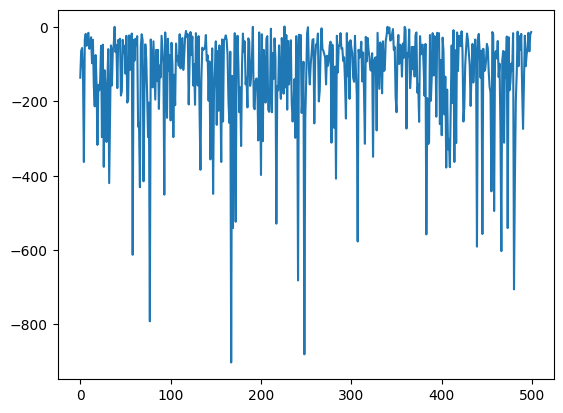

In [65]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

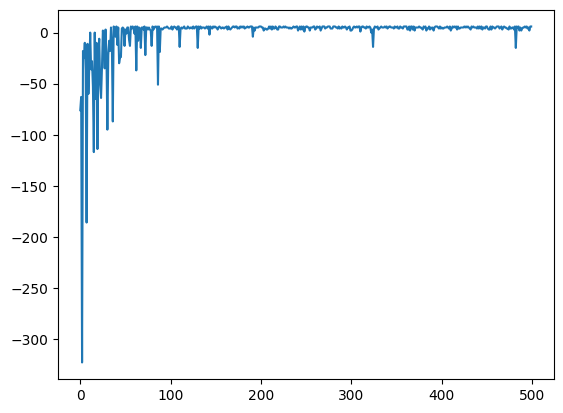

In [66]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [67]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.31000000000000005
	LEFT
		-0.30000000000000004
	RIGHT
		-0.28873
(0, 1)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		-0.2
	RIGHT
		3.308770222349087
(0, 2)
	UP
		3.070068439726285
	DOWN
		4.890107990783476
	LEFT
		0.2727482078128402
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0.7005810108684877
	DOWN
		1.912682726344981
	LEFT
		9.999955703072457
	RIGHT
		0.22468849584008663
(0, 5)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		3.169249140289115
	RIGHT
		-0.1
(0, 6)
	UP
		-0.4
	DOWN
		-0.31909
	LEFT
		-0.30901969
	RIGHT
		-0.4181
(0, 7)
	UP
		-0.5
	DOWN
		-0.5399639
	LEFT
		-0.4729
	RIGHT
		-0.5
(1, 0)
	UP
		-0.46829
	DOWN
		-0.44352600000000003
	LEFT
		-0.5
	RIGHT
		-0.35986668055189547
(1, 1)
	UP
		-0.271
	DOWN
		-0.21
	LEFT
		-0.209
	RIGHT
		5.121578045465189
(1, 2)
	UP
		8.999999999999986
	DOWN
		1.2408999919703259
	LEFT
		0.39458166798136496
	RIGHT
		-5.6953279000000006
(1, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(1, 4)
	

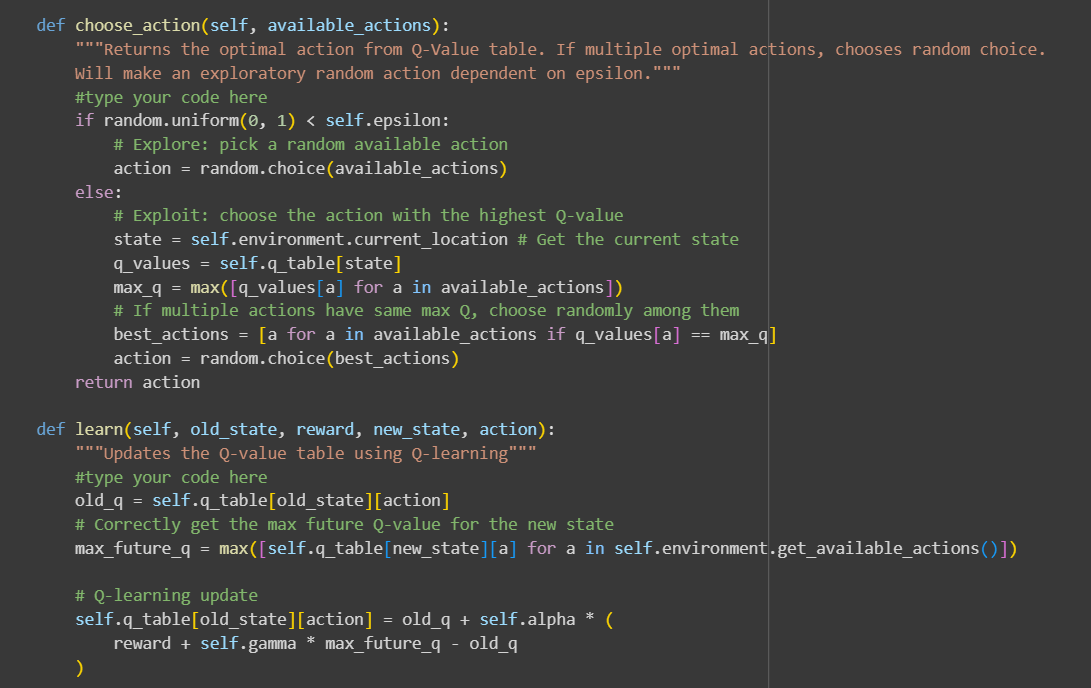

#Lab7 Part2

Training with epsilon = 0.1 ...
Training with epsilon = 0.5 ...
Training with epsilon = 0.9 ...


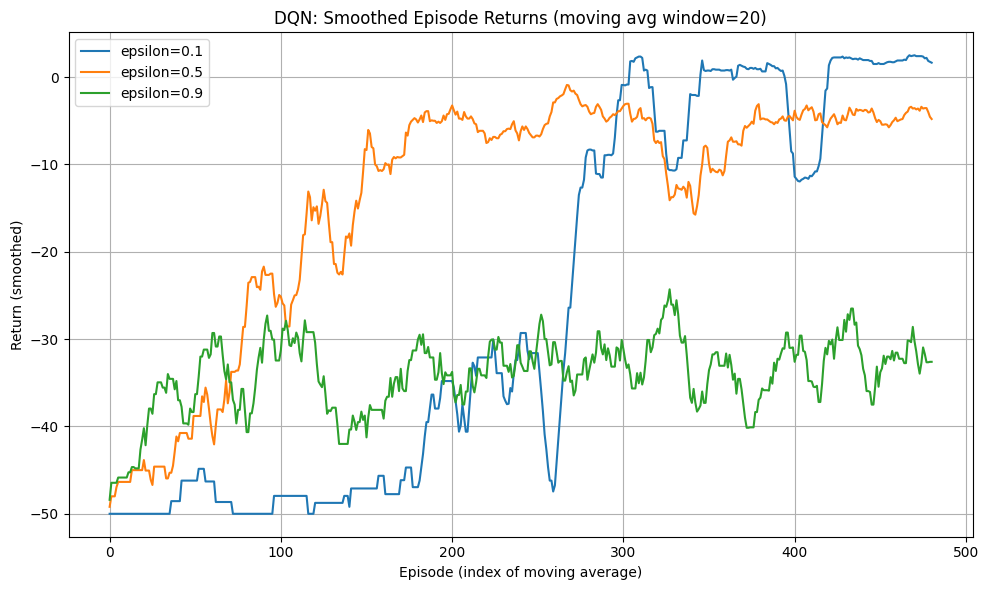

Epsilon=0.1: mean return last 50 episodes = 1.76, max return = 3.00
Epsilon=0.5: mean return last 50 episodes = -4.78, max return = 3.00
Epsilon=0.9: mean return last 50 episodes = -32.68, max return = 3.00

Saved results to ./dqn_results/dqn_gridworld_results.npz


In [68]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os


class GridWorld:
    def __init__(self, size=5, start=(0,0), goal=None, max_steps=50):
        self.size = size
        self.start = start
        self.pos = list(start)
        self.max_steps = max_steps
        self.steps = 0
        self.goal = goal if goal is not None else (size-1, size-1)
        self.n_states = size * size
        self.n_actions = 4  # up, down, left, right

    def reset(self):
        self.pos = list(self.start)
        self.steps = 0
        return self._state()

    def _state(self):
        s = np.zeros(self.n_states, dtype=np.float32)
        idx = self.pos[0] * self.size + self.pos[1]
        s[idx] = 1.0
        return s

    def step(self, action):
        # 0: up, 1: down, 2: left, 3: right
        if action == 0 and self.pos[0] > 0:
            self.pos[0] -= 1
        elif action == 1 and self.pos[0] < self.size - 1:
            self.pos[0] += 1
        elif action == 2 and self.pos[1] > 0:
            self.pos[1] -= 1
        elif action == 3 and self.pos[1] < self.size - 1:
            self.pos[1] += 1
        self.steps += 1
        done = tuple(self.pos) == self.goal or self.steps >= self.max_steps
        reward = 10.0 if tuple(self.pos) == self.goal else -1.0
        return self._state(), reward, done, {}

    def render(self):
        grid = [['.' for _ in range(self.size)] for _ in range(self.size)]
        gx, gy = self.goal
        sx, sy = self.start
        grid[gx][gy] = 'G'
        grid[sx][sy] = 'S'
        px, py = self.pos
        grid[px][py] = 'A'
        for row in grid:
            print(' '.join(row))
        print()


class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, done):
        self.buffer.append((s, a, r, s2, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = zip(*batch)
        return np.vstack(s), np.array(a), np.array(r, dtype=np.float32), np.vstack(s2), np.array(d, dtype=np.bool_)

    def __len__(self):
        return len(self.buffer)


class SimpleMLP:
    def __init__(self, input_dim, output_dim, hidden=64, lr=1e-3, seed=0):
        np.random.seed(seed)
        # Xavier-like init
        self.W1 = np.random.randn(input_dim, hidden) * np.sqrt(2.0/(input_dim + hidden))
        self.b1 = np.zeros((1, hidden))
        self.W2 = np.random.randn(hidden, output_dim) * np.sqrt(2.0/(hidden + output_dim))
        self.b2 = np.zeros((1, output_dim))
        self.lr = lr

    def forward(self, x):
        z1 = x.dot(self.W1) + self.b1        # shape (batch, hidden)
        a1 = np.tanh(z1)                     # activation
        z2 = a1.dot(self.W2) + self.b2       # shape (batch, output)
        return z2, a1

    def predict(self, x):
        q, _ = self.forward(x)
        return q

    def update(self, x, target_q):
        """
        Simple gradient descent on MSE loss: loss = mean((q - target_q)^2)
        x: (batch, input_dim)
        target_q: (batch, output_dim)
        """
        q, a1 = self.forward(x)
        error = q - target_q                      # (batch, output)
        batch = x.shape[0]

        # gradients
        d_out = (2.0 * error) / batch             # (batch, output)
        dW2 = a1.T.dot(d_out)                     # (hidden, output)
        db2 = d_out.sum(axis=0, keepdims=True)    # (1, output)

        da1 = d_out.dot(self.W2.T) * (1 - a1**2)  # tanh derivative -> (batch, hidden)
        dW1 = x.T.dot(da1)                        # (input, hidden)
        db1 = da1.sum(axis=0, keepdims=True)      # (1, hidden)

        # gradient step
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden=64, lr=1e-3, gamma=0.99, buffer_size=10000, batch_size=32, seed=0):
        self.q_net = SimpleMLP(state_dim, action_dim, hidden=hidden, lr=lr, seed=seed)
        self.target_net = SimpleMLP(state_dim, action_dim, hidden=hidden, lr=lr, seed=seed+1)
        self._copy_weights()
        self.gamma = gamma
        self.buffer = ReplayBuffer(capacity=buffer_size)
        self.batch_size = batch_size
        self.action_dim = action_dim
        self.steps = 0

    def _copy_weights(self):
        self.target_net.W1 = self.q_net.W1.copy()
        self.target_net.b1 = self.q_net.b1.copy()
        self.target_net.W2 = self.q_net.W2.copy()
        self.target_net.b2 = self.q_net.b2.copy()

    def act(self, state, epsilon=0.1):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        qvals = self.q_net.predict(state.reshape(1, -1))[0]
        return int(np.argmax(qvals))

    def push_experience(self, s, a, r, s2, done):
        self.buffer.push(s, a, r, s2, done)
        self.steps += 1

    def train_step(self, use_target=True):
        if len(self.buffer) < self.batch_size:
            return None
        s, a, r, s2, done = self.buffer.sample(self.batch_size)
        q = self.q_net.predict(s)   # (batch, actions)
        if use_target:
            q_next = self.target_net.predict(s2)
        else:
            q_next = self.q_net.predict(s2)
        q_target = q.copy()
        max_next = np.max(q_next, axis=1)
        for i in range(self.batch_size):
            q_target[i, a[i]] = r[i] + (0.0 if done[i] else self.gamma * max_next[i])
        self.q_net.update(s, q_target)
        loss = float(np.mean((q - q_target)**2))
        return loss

def train_dqn(env, epsilon, episodes=500, max_steps=50, target_update_freq=20, seed=0,
              hidden=64, lr=1e-3, buffer_size=5000, batch_size=32, gamma=0.99):
    random.seed(seed)
    np.random.seed(seed)
    agent = DQNAgent(state_dim=env.n_states, action_dim=env.n_actions, hidden=hidden, lr=lr,
                     gamma=gamma, buffer_size=buffer_size, batch_size=batch_size, seed=seed)
    episode_rewards = []
    losses = []
    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        for t in range(max_steps):
            a = agent.act(s, epsilon=epsilon)
            s2, r, done, _ = env.step(a)
            agent.push_experience(s, a, r, s2, done)
            loss = agent.train_step(use_target=True)
            if loss is not None:
                losses.append(loss)
            s = s2
            total_r += r
            if done:
                break
        episode_rewards.append(total_r)
        # periodic target network copy
        if (ep + 1) % target_update_freq == 0:
            agent._copy_weights()
    return np.array(episode_rewards), np.array(losses)

def moving_average(x, window=20):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

def run_experiment():
    # params
    env = GridWorld(size=5, start=(0,0), goal=(4,4), max_steps=50)
    epsilons = [0.1, 0.5, 0.9]
    episodes = 500
    results = {}
    out_dir = "./dqn_results"
    os.makedirs(out_dir, exist_ok=True)

    for eps in epsilons:
        print(f"Training with epsilon = {eps} ...")
        rewards, losses = train_dqn(env, epsilon=eps, episodes=episodes, max_steps=env.max_steps,
                                    target_update_freq=20, seed=42, hidden=64, lr=1e-3,
                                    buffer_size=5000, batch_size=32, gamma=0.99)
        results[eps] = {'rewards': rewards, 'losses': losses}

    # Plot smoothed returns
    plt.figure(figsize=(10,6))
    for eps in epsilons:
        r = results[eps]['rewards']
        ma = moving_average(r, window=20)
        plt.plot(np.arange(len(ma)), ma, label=f"epsilon={eps}")
    plt.title("DQN: Smoothed Episode Returns (moving avg window=20)")
    plt.xlabel("Episode (index of moving average)")
    plt.ylabel("Return (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "dqn_returns.png"))
    plt.show()

    # Print summaries
    for eps in epsilons:
        r = results[eps]['rewards']
        print(f"Epsilon={eps}: mean return last 50 episodes = {r[-50:].mean():.2f}, max return = {r.max():.2f}")

    # Save numeric results
    save_dict = {}
    for e in epsilons:
        key_r = f"eps_{int(e*10)}_rewards"
        key_l = f"eps_{int(e*10)}_losses"
        save_dict[key_r] = results[e]['rewards']
        save_dict[key_l] = results[e]['losses']
    save_path = os.path.join(out_dir, "dqn_gridworld_results.npz")
    np.savez(save_path, **save_dict)
    print(f"\nSaved results to {save_path}")

if __name__ == "__main__":
    run_experiment()


In [ ]:
import random
import collections
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# ---------------- Replay Buffer ----------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, bool(done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(list, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# ---------------- Q-Network ----------------
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(128, 128)):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ---------------- DQN Agent ----------------
class DQNAgent:
    def __init__(self,
                 obs_dim,
                 action_dim,
                 device='cpu',
                 hidden_dims=(128, 128),
                 lr=1e-3,
                 gamma=0.99,
                 buffer_size=100000,
                 batch_size=64,
                 min_buffer_size=1000,
                 target_update_freq_steps=1000,
                 use_replay=True,
                 use_target=True,
                 seed=0):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.device = torch.device(device)
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.min_buffer_size = min_buffer_size
        self.use_replay = use_replay
        self.use_target = use_target
        self.target_update_freq_steps = target_update_freq_steps

        # Networks
        self.q_net = QNetwork(obs_dim, action_dim, hidden_dims).to(self.device)
        if self.use_target:
            self.target_net = QNetwork(obs_dim, action_dim, hidden_dims).to(self.device)
            self._copy_target()
        else:
            self.target_net = None

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        # Replay buffer
        self.replay = ReplayBuffer(buffer_size) if use_replay else None

        # Step counters
        self.total_steps = 0
        self.train_steps = 0

    def _copy_target(self):
        if self.target_net is not None:
            self.target_net.load_state_dict(self.q_net.state_dict())

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state_v = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            qvals = self.q_net(state_v)
        return int(torch.argmax(qvals, dim=1).item())

    def store_transition(self, s, a, r, s2, done):
        if self.use_replay:
            self.replay.push(s, a, r, s2, done)

    def train_step(self):
        if not self.use_replay or len(self.replay) < self.min_buffer_size:
            return None

        s, a, r, s2, done = self.replay.sample(self.batch_size)

        states = torch.tensor(s, dtype=torch.float32, device=self.device)
        actions = torch.tensor(a, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(r, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(s2, dtype=torch.float32, device=self.device)
        dones = torch.tensor(done, dtype=torch.float32, device=self.device).unsqueeze(1)

        # Current Q values
        q_values = self.q_net(states).gather(1, actions)

        # Compute target
        with torch.no_grad():
            next_q = self.target_net(next_states) if self.use_target and self.target_net else self.q_net(next_states)
            max_next_q = next_q.max(dim=1, keepdim=True)[0]
            q_targets = rewards + (1.0 - dones) * self.gamma * max_next_q

        # Loss and optimization
        loss = F.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_net.parameters(), 10.0)
        self.optimizer.step()

        self.train_steps += 1
        return loss.item()

    def maybe_update_target(self):
        if self.use_target and self.target_net and self.total_steps % self.target_update_freq_steps == 0:
            self._copy_target()


# ---------------- Training Loop ----------------
def train(env,
          agent,
          episodes=800,
          max_steps_per_episode=1000,
          epsilon_start=1.0,
          epsilon_final=0.01,
          epsilon_decay_episodes=500,
          eval_every=50,
          render=False):
    rewards_history = []
    eps_history = []
    loss_history = []

    epsilon_by_episode = lambda ep: max(
        epsilon_final,
        epsilon_start - (epsilon_start - epsilon_final) * (ep / max(1, epsilon_decay_episodes))
    )

    for ep in range(1, episodes + 1):
        s = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
        ep_reward = 0.0
        epsilon = epsilon_by_episode(ep)

        for step in range(max_steps_per_episode):
            a = agent.act(s, epsilon)
            s2, r, done, _, *_ = env.step(a)
            agent.total_steps += 1
            ep_reward += r

            agent.store_transition(s, a, r, s2, done)
            loss = agent.train_step()
            if loss is not None:
                loss_history.append(loss)
            agent.maybe_update_target()

            s = s2
            if done:
                break

        rewards_history.append(ep_reward)
        eps_history.append(epsilon)

        if ep % 10 == 0:
            avg_last = np.mean(rewards_history[-100:])
            print(f"Ep {ep:4d} | Reward {ep_reward:7.2f} | Avg100 {avg_last:7.2f} | Eps {epsilon:.3f} | Steps {agent.total_steps} | LossSteps {len(loss_history)}")

    return {'rewards': np.array(rewards_history),
            'eps': np.array(eps_history),
            'losses': np.array(loss_history)}


# ---------------- Evaluation ----------------
def evaluate(env, agent, episodes=10, max_steps=1000, render=False):
    rewards = []
    for _ in range(episodes):
        s = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
        total = 0.0
        for _ in range(max_steps):
            a = agent.act(s, epsilon=0.0)
            s, r, done, _, *_ = env.step(a)
            total += r
            if render:
                env.render()
            if done:
                break
        rewards.append(total)
    return np.mean(rewards), np.std(rewards)


# ---------------- Run Experiments ----------------
def run_experiments(env_name='LunarLander-v2',
                    episodes=600,
                    seed=0,
                    device='cpu',
                    compare_configs=True):
    env = gym.make(env_name)
    env.reset(seed=seed)
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    results = {}

    configs = [
        {'name': 'replay+target', 'use_replay': True, 'use_target': True},
        {'name': 'no_replay_no_target', 'use_replay': False, 'use_target': False},
        {'name': 'replay_no_target', 'use_replay': True, 'use_target': False},
        {'name': 'no_replay_target', 'use_replay': False, 'use_target': True},
    ] if compare_configs else [{'name': 'replay+target', 'use_replay': True, 'use_target': True}]

    for cfg in configs:
        print("\n" + "="*60)
        print("Config:", cfg['name'], "| replay:", cfg['use_replay'], " | target:", cfg['use_target'])

        agent = DQNAgent(obs_dim, action_dim, device=device,
                         hidden_dims=(256, 128), lr=1e-3, gamma=0.99,
                         buffer_size=100000, batch_size=64, min_buffer_size=2000,
                         target_update_freq_steps=1000,
                         use_replay=cfg['use_replay'], use_target=cfg['use_target'], seed=seed)

        logs = train(env, agent, episodes=episodes, max_steps_per_episode=1000,
                     epsilon_start=1.0, epsilon_final=0.01,
                     epsilon_decay_episodes=int(episodes*0.6),
                     eval_every=50, render=False)

        mean_r, std_r = evaluate(env, agent, episodes=10, max_steps=1000, render=False)
        print(f"Final evaluation (10 eps): mean reward = {mean_r:.2f} ± {std_r:.2f}")

        results[cfg['name']] = {'logs': logs, 'agent': agent, 'eval_mean': mean_r, 'eval_std': std_r}

        # Save logs
        os.makedirs('dqn_runs', exist_ok=True)
        np.savez(f"dqn_runs/{env_name}_{cfg['name']}_logs.npz",
                 rewards=logs['rewards'], eps=logs['eps'], losses=logs['losses'])

    env.close()
    return results


# ---------------- Plot Results ----------------
def plot_results(results, episodes):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for name, res in results.items():
        r = res['logs']['rewards']
        window = max(1, episodes // 50)
        smoothed = np.convolve(r, np.ones(window) / window, mode='valid')
        plt.plot(np.arange(len(smoothed)), smoothed, label=name)
    plt.xlabel('Episode (smoothed)')
    plt.ylabel('Episode reward (smoothed)')
    plt.title('Episode reward vs Episode')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for name, res in results.items():
        e = res['logs']['eps']
        plt.plot(np.arange(len(e)), e, label=name)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon vs Episode')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('dqn_runs/summary_plot.png')
    plt.show()


# ---------------- Main ----------------
if __name__ == '__main__':
    start_time = time.time()
    results = run_experiments(env_name='LunarLander-v2', episodes=600, seed=42, device='cpu', compare_configs=True)
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time/60:.2f} minutes")

    plot_results(results, episodes=600)

    print("\nSummary of final evaluations:")
    for name, r in results.items():
        print(f"{name}: mean {r['eval_mean']:.2f}, std {r['eval_std']:.2f}")



Config: replay+target | replay: True  | target: True
Ep   10 | Reward -177.62 | Avg100 -172.91 | Eps 0.973 | Steps 927 | LossSteps 0
Ep   20 | Reward -257.81 | Avg100 -190.08 | Eps 0.945 | Steps 1901 | LossSteps 0
Ep   30 | Reward -197.80 | Avg100 -181.47 | Eps 0.917 | Steps 2818 | LossSteps 819
Ep   40 | Reward -107.47 | Avg100 -168.92 | Eps 0.890 | Steps 3779 | LossSteps 1780
Ep   50 | Reward -165.93 | Avg100 -164.28 | Eps 0.863 | Steps 4811 | LossSteps 2812
Ep   60 | Reward  -99.42 | Avg100 -164.31 | Eps 0.835 | Steps 5750 | LossSteps 3751
Ep   70 | Reward  -38.96 | Avg100 -161.40 | Eps 0.807 | Steps 6807 | LossSteps 4808
Ep   80 | Reward -116.03 | Avg100 -155.83 | Eps 0.780 | Steps 7891 | LossSteps 5892
Ep   90 | Reward -116.83 | Avg100 -152.34 | Eps 0.752 | Steps 8910 | LossSteps 6911
Ep  100 | Reward -100.82 | Avg100 -147.08 | Eps 0.725 | Steps 10039 | LossSteps 8040
Ep  110 | Reward  -59.51 | Avg100 -137.82 | Eps 0.698 | Steps 11270 | LossSteps 9271
Ep  120 | Reward -206.61 | A

In [ ]:
pip install swig

In [ ]:
pip install gymnasium[box2d]

In [ ]:
import numpy as np

# Patch for deprecated np.bool8
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_